<a href="https://colab.research.google.com/github/Chesta1/Fruit_classification/blob/main/Fruit_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🥝**Fruit Classification**

#### Introduction 
The technique which have been used for doing the Fruit Image Classification here is known as **Transfer Learning** technique, which means it provides us a leverage to use other models weights that algorithm has learnt on a very similar type of the problem while learning the patterns in data.


With the help of transfer learning we can achieve a higher accuracy when compared to build **Convolutional Neural Network** from scratch.

In this notebook for doing Image Classification we have leveraged to take an advantage of the patterns and weights that **ResNet50V2** has learnt.

Have also tried to use EfficientNet but the results are not good.

1. Import all necessary libraries that has been required to work on data and to built the model 


In [74]:
#import the libraries
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib.image as mpimg
import seaborn as sns
import random
import zipfile
import pathlib


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential
import datetime
from tensorflow.keras.applications import EfficientNetB0, ResNet50V2
from tensorflow.keras.preprocessing import image

from sklearn.metrics import confusion_matrix


2. To directly download the dataset from kaggle to **Google Colab** below commands are necessary

In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d utkarshsaxenadn/fruits-classification

 95% 81.0M/84.8M [00:03<00:00, 29.5MB/s]
100% 84.8M/84.8M [00:03<00:00, 26.4MB/s]


3. To extract the files from **Zip Folder**

In [4]:
zip_ref = zipfile.ZipFile('fruits-classification.zip',"r")

zip_ref.extractall()
zip_ref.close()

4. Inspect the data to find out how many directories are there in the folder and in each directory how many files are present.

In [75]:
for dirpath,dirname,filename in os.walk("Fruits_Classification"):
  print(f'There are {len(dirname)} directories and {len(filename)} images in {dirpath}')

There are 3 directories and 1 images in Fruits_Classification
There are 5 directories and 0 images in Fruits_Classification/test
There are 0 directories and 20 images in Fruits_Classification/test/Banana
There are 0 directories and 20 images in Fruits_Classification/test/Grape
There are 0 directories and 20 images in Fruits_Classification/test/Apple
There are 0 directories and 20 images in Fruits_Classification/test/Strawberry
There are 0 directories and 20 images in Fruits_Classification/test/Mango
There are 5 directories and 0 images in Fruits_Classification/train
There are 0 directories and 1940 images in Fruits_Classification/train/Banana
There are 0 directories and 1940 images in Fruits_Classification/train/Grape
There are 0 directories and 1940 images in Fruits_Classification/train/Apple
There are 0 directories and 1940 images in Fruits_Classification/train/Strawberry
There are 0 directories and 1940 images in Fruits_Classification/train/Mango
There are 5 directories and 0 images

5. In data we are dealing with **Multi-Class classification** problem where we have 5 classes of fruits. Thus, to store the names folr each class below code is required.

In [6]:
data_dir= pathlib.Path("Fruits_Classification/train")
class_names = [i.name for i in data_dir.glob('*')]
class_names

['Banana', 'Grape', 'Apple', 'Strawberry', 'Mango']

6. Define a function to Visualize the data or the image for target class and  pick any one random sample from the directory with its Label.

In [8]:

def view_random_image(target_dir,target_class):
  #setup target directory
  target_folder = target_dir+"/"+target_class
  # print(target_folder)
  #get the random image from the target dir and targetclass
  random_image = random.sample(os.listdir(target_folder),1)
  print(random_image[0])

  #read the image and plot
  img = mpimg.imread(target_folder+"/"+random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis('off')

  print(f'Image shape:{img.shape}')

  return img

Apple (1917).jpeg
Image shape:(234, 216, 3)


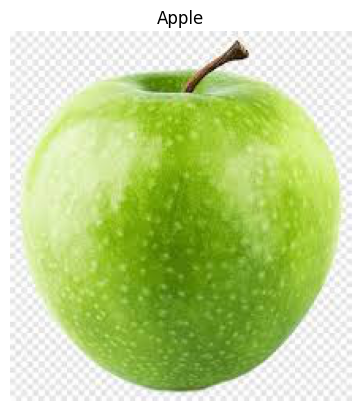

In [9]:
img =view_random_image(target_dir="Fruits_Classification/train",target_class='Apple')

7. With the help of **ImageDataGenerator** we can apply random transformations on each of training images while our model is still in training process.

   Here we have done only rescaling of the images that leads to values between the range of 0 and 1(**normalization**).

  🔑 If we want to apply more of **data augmentation** techniques like rotation of image, change of width and height, zoom, flipping etc. this should be valid on the training imagws only

 Here we have applied ImageGenerator class with **flow_from_directory**

In [11]:
Image_shape=(224,224)
Batch_size=32

train_dir='/content/Fruits_Classification/train/'
val_dir='/content/Fruits_Classification/valid/'

train_data_gen = ImageDataGenerator(rescale=1/255)
val_data_gen = ImageDataGenerator(rescale=1/255)

train_data = train_data_gen.flow_from_directory(train_dir,target_size=Image_shape,
                                                        batch_size=Batch_size,
                                                        class_mode='categorical')

valid_data = val_data_gen.flow_from_directory(val_dir,
                                              target_size=Image_shape,
                                              batch_size=Batch_size,
                                              class_mode='categorical')

Found 9700 images belonging to 5 classes.
Found 200 images belonging to 5 classes.


8. **Callbacks** are extra functionality to perform during and after training

* tracking experiments
* model checkpoint
* early stopping before overfitting

Some popular Callbacks are: -
 * Tensorbaord

 * ModelCheckpoint

 * Earlystopping

In [12]:
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir=dir_name+'/'+experiment_name+'/'+datetime.datetime.now().strftime('%Y%m%d-%H')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f'saving tensorboardcallback:{log_dir}')
  return tensorboard_callback


9. With the help of **Functional API** we are building our first Tensorflow Transfer Learning Model with the help of **ResNet50V2**.

  While working on the model using transfer learning we are using the **FeatureExtraction Technique** here. That means we are leveraging the weights of the model and adjusting those weights which would be suited for our classification problem. 
  
  🗒Over here we'll freeze all the leraned patterns in the bottom layers and we'll adjust the weights of top2-3 pretrained layers of the model in accordance with our custom data.
  This is our **Base Line** model which provides an accuracy of 84 on validation data.


In [14]:
base_model = ResNet50V2(include_top=False)

base_model.trainable = False

inputs = tf.keras.layers.Input(shape=(224,224,3),name='input_layer')

x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)# resnet model does not have the the normalized layers 
x = base_model(inputs)

print(f'Shape after base_model:{x.shape}')

x = tf.keras.layers.GlobalAveragePooling2D(name='gloabl_average2D')(x)
print(f'Global average 2D pooling shape:{x.shape}')

# x = Dense(128,activation='relu')(x)

outputs = tf.keras.layers.Dense(5,activation='softmax',name='output_layer')(x)

model_0=tf.keras.Model(inputs,outputs)

model_0.compile(loss='categorical_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

history_transferlearning_0= model_0.fit(train_data,
                                        epochs=10,
                                        steps_per_epoch=len(train_data),
                                        validation_data=valid_data,
                                        validation_steps=int(0.25*len(valid_data)),
                                        callbacks=[create_tensorboard_callback("transfer_learning",'transfer_learning_featureextraction')])



94668760/94668760 [==============================] - 3s 0us/step
Shape after base_model:(None, 7, 7, 2048)
Global average 2D pooling shape:(None, 2048)
saving tensorboardcallback:transfer_learning/transfer_learning_featureextraction/20230415-03
Epoch 1/10
304/304 [==============================] - 44s 103ms/step - loss: 0.5731 - accuracy: 0.7962 - val_loss: 0.3940 - val_accuracy: 0.8750
Epoch 2/10
304/304 [==============================] - 30s 98ms/step - loss: 0.3648 - accuracy: 0.8727 - val_loss: 0.2662 - val_accuracy: 0.9062
Epoch 3/10
304/304 [==============================] - 29s 95ms/step - loss: 0.3087 - accuracy: 0.8911 - val_loss: 0.3678 - val_accuracy: 0.8438
Epoch 4/10
304/304 [==============================] - 30s 99ms/step - loss: 0.2686 - accuracy: 0.9048 - val_loss: 0.2064 - val_accuracy: 0.9375
Epoch 5/10
304/304 [==============================] - 29s 96ms/step - loss: 0.2399 - accuracy: 0.9159 - val_loss: 0.1719 - val_accuracy: 0.9062
Epoch 6/10
304/304 [==============

10. Second Model where we have added a Dropout Layer to see the impact on the accuracy in comparison to our Baseline model we have created above.

  But able to notice that the accuracy decreased.

  We can do further more experiments to increase the accuracy via using **Data Augmenttaion** technique or by using other pre-trained model example **MobileNetV2**.

In [15]:
base_model = ResNet50V2(include_top=False)

base_model.trainable = False

inputs = tf.keras.layers.Input(shape=(224,224,3),name='input_layer')

x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)
x = base_model(inputs)

print(f'Shape after base_model:{x.shape}')

x = tf.keras.layers.GlobalAveragePooling2D(name='gloabl_average2D')(x)
print(f'Global average 2D pooling shape:{x.shape}')

# x = Dense(128,activation='relu')(x)
x= tf.keras.layers.Dropout(0.2)(x)


outputs = tf.keras.layers.Dense(5,activation='softmax',name='output_layer')(x)

model_1=tf.keras.Model(inputs,outputs)

model_1.compile(loss='categorical_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

history_transferlearning_1= model_1.fit(train_data,
                                        epochs=10,
                                        steps_per_epoch=len(train_data),
                                        validation_data=valid_data,
                                        validation_steps=int(0.25*len(valid_data)),
                                        callbacks=[create_tensorboard_callback("transfer_learning",'transfer_learning_featureextraction2')])

Shape after base_model:(None, 7, 7, 2048)
Global average 2D pooling shape:(None, 2048)
saving tensorboardcallback:transfer_learning/transfer_learning_featureextraction2/20230415-03
Epoch 1/10
304/304 [==============================] - 35s 103ms/step - loss: 0.6363 - accuracy: 0.7671 - val_loss: 0.5726 - val_accuracy: 0.8438
Epoch 2/10
304/304 [==============================] - 29s 96ms/step - loss: 0.4223 - accuracy: 0.8490 - val_loss: 0.3931 - val_accuracy: 0.9062
Epoch 3/10
304/304 [==============================] - 30s 99ms/step - loss: 0.3700 - accuracy: 0.8708 - val_loss: 0.6045 - val_accuracy: 0.7812
Epoch 4/10
304/304 [==============================] - 29s 96ms/step - loss: 0.3387 - accuracy: 0.8802 - val_loss: 0.3122 - val_accuracy: 0.9062
Epoch 5/10
304/304 [==============================] - 31s 101ms/step - loss: 0.3209 - accuracy: 0.8830 - val_loss: 0.2552 - val_accuracy: 0.8750
Epoch 6/10
304/304 [==============================] - 30s 99ms/step - loss: 0.3042 - accuracy: 0.

11. **Visualization** Plotting the Loss and Accuracy on Training and Validation data.

In [71]:
def plot_loss_curves(history):
  loss=history.history['loss']
  val_loss=history.history['val_loss']

  accuracy=history.history['accuracy']
  val_accuracy=history.history['val_accuracy']

  epochs= range(len(history.history['loss']))

  #plotloss
  plt.plot(epochs,loss,label='training_loss')
  plt.plot(epochs,val_loss,label='val_loss')
  plt.title('loss')
  plt.xlabel('epochs')
  plt.legend()

  #plotaccuracy
  plt.figure()
  plt.plot(epochs,accuracy,label='training_accuracy')
  plt.plot(epochs,val_accuracy,label='val_accuracy')
  plt.title('accuracy')
  plt.xlabel('epochs')
  plt.legend()

In [16]:
# find indices of train_data
train_data.class_indices

{'Apple': 0, 'Banana': 1, 'Grape': 2, 'Mango': 3, 'Strawberry': 4}

12. To look for **Predictions** on image from the model.

*Below code can be converted to function, so we can utilize the function again and again without writing the whole code

[[[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 ...

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]]
1/1 [==============================] - 0s 31ms/step
[[3.1698530e-03 8.2268240e-04 9.3400369e-05 9.9590731e-01 6.7473875e-06]]
3


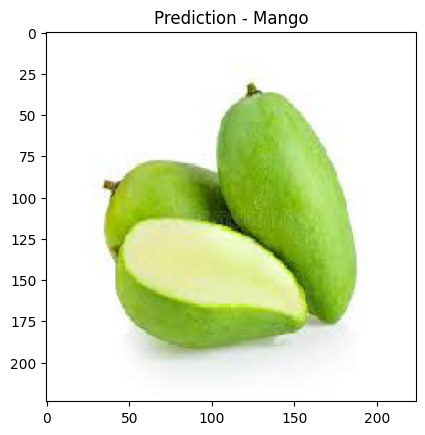

In [20]:

category = {
    0:'Apple',
    1:'Banana',
    2:'Grape',
    3:'Mango',
    4:'Strawberry'
}

img_=image.load_img('/content/Fruits_Classification/valid/Mango/Mango (1306).jpeg',target_size=(224,224))
img_array = image.img_to_array(img_)
print(img_array)
img_processed = np.expand_dims(img_array,axis=0)
img_processed /= 255

prediction = model_0.predict(img_processed)
print(prediction)
index = np.argmax(prediction)
print(index)
plt.title("Prediction - {}".format(category[index]))
plt.imshow(img_array)




[[[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 ...

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]]
1/1 [==============================] - 0s 102ms/step
[[9.2564933e-06 9.9994648e-01 6.4698929e-06 3.5236182e-05 2.5335739e-06]]
1


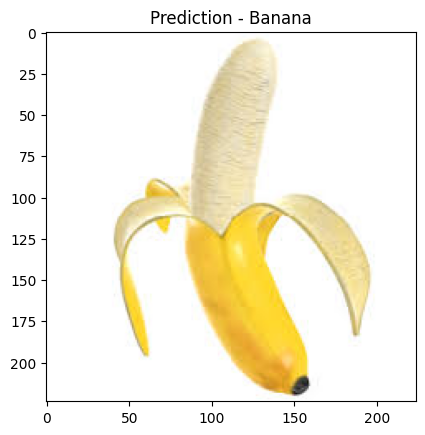

In [21]:
img_=image.load_img('//content/Fruits_Classification/valid/Banana/Banana (2955).jpeg',target_size=(224,224))
img_array = image.img_to_array(img_)
print(img_array)
img_processed = np.expand_dims(img_array,axis=0)
img_processed /= 255

prediction = model_0.predict(img_processed)
print(prediction)
index = np.argmax(prediction)
print(index)
plt.title("Prediction - {}".format(category[index]))
plt.imshow(img_array)

[[[186. 182. 179.]
  [120. 116. 113.]
  [181. 177. 174.]
  ...
  [ 72.  99. 110.]
  [ 79. 111. 126.]
  [ 79. 111. 126.]]

 [[188. 184. 181.]
  [151. 147. 144.]
  [178. 174. 171.]
  ...
  [ 71.  98. 109.]
  [ 75. 107. 122.]
  [ 75. 107. 122.]]

 [[195. 191. 188.]
  [123. 119. 116.]
  [169. 165. 162.]
  ...
  [ 69.  96. 107.]
  [ 73. 102. 116.]
  [ 73. 102. 116.]]

 ...

 [[102.  83.  87.]
  [ 99.  83.  86.]
  [ 91.  75.  76.]
  ...
  [145. 111.  48.]
  [145. 116.  58.]
  [160. 131.  73.]]

 [[103.  84.  88.]
  [ 99.  83.  86.]
  [ 92.  76.  77.]
  ...
  [140. 105.  39.]
  [106.  78.  13.]
  [ 97.  69.   4.]]

 [[104.  85.  89.]
  [100.  84.  87.]
  [ 93.  77.  78.]
  ...
  [130.  93.  25.]
  [ 92.  64.   0.]
  [ 95.  67.   2.]]]
1/1 [==============================] - 0s 41ms/step
[[2.6669754e-03 9.9500388e-01 1.6985832e-04 2.1517163e-03 7.4165532e-06]]
1


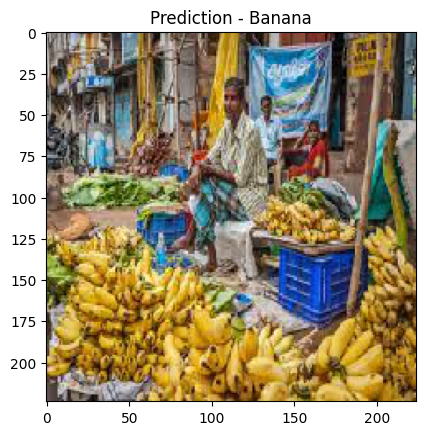

In [22]:
img_=image.load_img('/content/Fruits_Classification/test/Banana/Banana (3652).jpeg',target_size=(224,224))
img_array = image.img_to_array(img_)
print(img_array)
img_processed = np.expand_dims(img_array,axis=0)
img_processed /= 255

prediction = model_0.predict(img_processed)
print(prediction)
index = np.argmax(prediction)
print(index)
plt.title("Prediction - {}".format(category[index]))
plt.imshow(img_array)

[[[148. 165. 157.]
  [148. 165. 157.]
  [ 59.  76.  68.]
  ...
  [174. 185. 153.]
  [178. 189. 155.]
  [178. 189. 155.]]

 [[148. 165. 157.]
  [148. 165. 157.]
  [ 59.  76.  68.]
  ...
  [174. 185. 153.]
  [178. 189. 155.]
  [178. 189. 155.]]

 [[148. 165. 157.]
  [148. 165. 157.]
  [ 59.  76.  68.]
  ...
  [174. 185. 153.]
  [178. 189. 155.]
  [178. 189. 155.]]

 ...

 [[234. 250. 237.]
  [234. 250. 237.]
  [151. 167. 154.]
  ...
  [185. 205. 144.]
  [184. 204. 143.]
  [184. 204. 143.]]

 [[234. 250. 237.]
  [234. 250. 237.]
  [151. 167. 154.]
  ...
  [185. 205. 144.]
  [184. 204. 143.]
  [184. 204. 143.]]

 [[234. 250. 237.]
  [234. 250. 237.]
  [151. 167. 154.]
  ...
  [185. 205. 144.]
  [184. 204. 143.]
  [184. 204. 143.]]]
1/1 [==============================] - 0s 73ms/step
[[6.8825036e-02 2.7303788e-04 1.6186105e-03 9.2917120e-01 1.1213555e-04]]
3


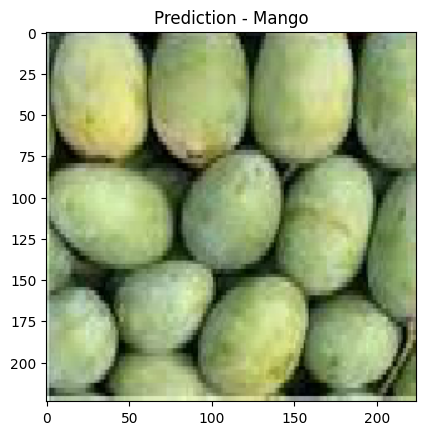

In [24]:
img_=image.load_img('/content/Fruits_Classification/test/Mango/Mango (1862).jpeg',target_size=(224,224))
img_array = image.img_to_array(img_)
print(img_array)
img_processed = np.expand_dims(img_array,axis=0)
img_processed /= 255

prediction = model_0.predict(img_processed)
print(prediction)
index = np.argmax(prediction)
print(index)
plt.title("Prediction - {}".format(category[index]))
plt.imshow(img_array)

13. **Evaluation Metrics** Let's find the other metrics values and those are:-

* Precision
* Recall
* F1 score

this we'll find with the help of **classification report** and also try to find the **confusion matrix** for all the classes.

In [29]:
len(os.listdir('/content/Fruits_Classification/test/Banana/'))

20

In [36]:
filedir = '/content/Fruits_Classification/test/Banana'

In [37]:
filedir.split('/')[-1]

'Banana'

14. Function to define the accuracy for each class by doing preprocessing of the images in the test data. So all images in the test data converted to tensors having the exact input shape that we have provided to the images trained in the model.

In [46]:
def predict_dir(filedir,model):
  cols=3
  pos=0
  images=[]
  total_images=len(os.listdir(filedir))
  rows=(total_images//cols+1)
  true = filedir.split('/')[-1]

  for i in sorted(os.listdir(filedir)):
    images.append(os.path.join(filedir,i))

  for subplot,imgg in enumerate(images):
    img_ = image.load_img(imgg,target_size=(224,224))
    img_array = image.img_to_array(img_)
    
    img_processed = np.expand_dims(img_array,axis=0)
    img_processed /= 255

    prediction = model.predict(img_processed)
    index = np.argmax(prediction)

    pred = category.get(index)
    if pred==true:
      pos+=1
  accu = pos/total_images
  print("Accuracy for {orignal}: {:.2f} ({pos}/{total})".format(accu,pos=pos,total=total_images,orignal=true))

15. **Accuracy** for each calss in the test directory. How many of the images have been correctly classified

In [48]:
for i in os.listdir('/content/Fruits_Classification/test'):
  # print(i)
  predict_dir(os.path.join('/content/Fruits_Classification/test',i),model_0)

1/1 [==============================] - 0s 40ms/step
Accuracy for Banana: 0.90 (18/20)
1/1 [==============================] - 0s 26ms/step
Accuracy for Grape: 1.00 (20/20)
1/1 [==============================] - 0s 25ms/step
Accuracy for Apple: 0.80 (16/20)
1/1 [==============================] - 0s 26ms/step
Accuracy for Strawberry: 0.85 (17/20)
1/1 [==============================] - 0s 24ms/step
Accuracy for Mango: 0.80 (16/20)


16. Check the accuracy for each label in the test dataset using **confusion_matrix** heat map **Visualization**

In [66]:
from tensorflow.keras.preprocessing import image

def labels_confusion_matix(folder):
  mapping ={}
  for i,j in enumerate(sorted(os.listdir(folder))):
    # print(i)
    # print(j)
    
    mapping[j]=i
  files=[]
  real=[]
  predicted=[]

  for i in os.listdir(folder):
    true = os.path.join(folder,i)
    true = true.split('/')[-1]
    # print(true)
    true = (mapping[true])

    for j in os.listdir(os.path.join(folder,i)):
      img_ = image.load_img(os.path.join(folder,i,j), target_size=(224,224))
      img_array = image.img_to_array(img_)

      img_processed = np.expand_dims(img_array,axis=0)
      img_processed /=255

      prediction = model_0.predict(img_processed)

      index = np.argmax(prediction)

      predicted.append(index)
      real.append(true)
  return real,predicted





In [68]:

def print_confusion_matrix(real,predicted):
  total_output_labels=5
  cmap='turbo'

  cm_plot_labels=[i for i in range(5)]

  cm = confusion_matrix(y_true=real,y_pred=predicted)

  df_cm = pd.DataFrame(cm,cm_plot_labels,cm_plot_labels)

  sns.set(font_scale=1.2)

  plt.figure(figsize=(15,10))

  s=sns.heatmap(df_cm,fmt="d", annot=True,cmap=cmap)

  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.savefig('confusion_matrix.png')
  plt.show()






1/1 [==============================] - 0s 26ms/step


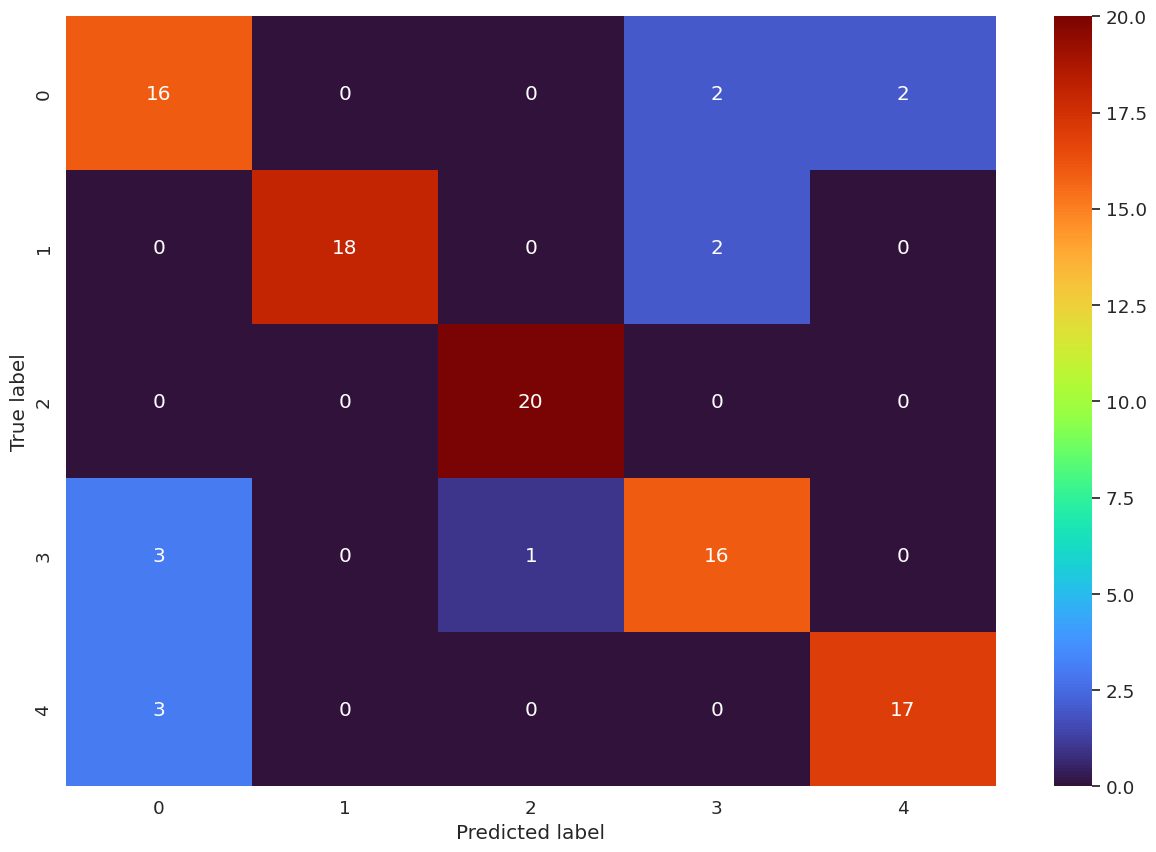

In [70]:
y_true,y_pred=labels_confusion_matix('/content/Fruits_Classification/test')
print_confusion_matrix(y_true,y_pred)